# 1. Importing Libraries

In [1]:
# Add required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

#from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error,accuracy_score

import optuna
seed =42 # for repeatability
%matplotlib inline


# 2. Getting Data

In [2]:
# Load data set
# Add path for the data set
path = 'D:\Ascendeum\DataScientist_L2\DataScientist_L2/Ascendeum_Dataset2.csv'
df = pd.read_csv(path)
Xact = df

# 3. Understanding Data

In [3]:
df.head() 

,date,site_id,ad_type_id,geo_id,device_category_id,advertiser_id,order_id,line_item_type_id,os_id,integration_type_id,monetization_channel_id,ad_unit_id,total_impressions,total_revenue,viewable_impressions,measurable_impressions,revenue_share_percent
0,2019-06-30 00:00:00,351,10,187,2,84,3473,19,60,1,4,5174,16,0.0,2,16,1
1,2019-06-30 00:00:00,351,10,187,2,84,3473,19,58,1,4,5174,6,0.0,0,6,1
2,2019-06-30 00:00:00,351,10,147,2,84,3473,19,60,1,4,5174,4,0.0,0,4,1
3,2019-06-30 00:00:00,351,10,147,2,84,3473,19,58,1,4,5174,4,0.0,0,4,1
4,2019-06-30 00:00:00,348,10,147,3,79,3463,20,59,1,19,5138,4,0.0,0,4,1


In [4]:
df.shape

(567291, 17)

In [5]:
# converting date column to datetime 
df['date'] = pd.to_datetime(df['date'],errors='coerce')

# 4. Data cleaning

In [6]:
 df.isnull().sum() # Check the missing elements

date                       0
site_id                    0
ad_type_id                 0
geo_id                     0
device_category_id         0
advertiser_id              0
order_id                   0
line_item_type_id          0
os_id                      0
integration_type_id        0
monetization_channel_id    0
ad_unit_id                 0
total_impressions          0
total_revenue              0
viewable_impressions       0
measurable_impressions     0
revenue_share_percent      0
dtype: int64

# 5. Data analysis

In [7]:
df.info() # Check the data type of the variables

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567291 entries, 0 to 567290
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   date                     567291 non-null  datetime64[ns]
 1   site_id                  567291 non-null  int64         
 2   ad_type_id               567291 non-null  int64         
 3   geo_id                   567291 non-null  int64         
 4   device_category_id       567291 non-null  int64         
 5   advertiser_id            567291 non-null  int64         
 6   order_id                 567291 non-null  int64         
 7   line_item_type_id        567291 non-null  int64         
 8   os_id                    567291 non-null  int64         
 9   integration_type_id      567291 non-null  int64         
 10  monetization_channel_id  567291 non-null  int64         
 11  ad_unit_id               567291 non-null  int64         
 12  total_impression

In [8]:
# checking for duplicate rows
print(df.shape[0])
print(f'Number of duplicated rows: {df.shape[0] - df.drop_duplicates().shape[0]}')
print('dropping duplicates')
df = df.drop_duplicates()

567291
Number of duplicated rows: 23164
dropping duplicates


In [9]:
df.shape

(544127, 17)

In [10]:
# Add varibles
df['weekday'] = df['date'].apply(lambda x:x.weekday())
df['View_perc'] = np.where(df['measurable_impressions']!=0,
                           df['viewable_impressions']/df['measurable_impressions'],0)

C:\Users\JD\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\JD\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [11]:
df.nunique() # Count Distinct Values

date                          30
site_id                       10
ad_type_id                     2
geo_id                       219
device_category_id             5
advertiser_id                 23
order_id                      75
line_item_type_id              7
os_id                          7
integration_type_id            1
monetization_channel_id        5
ad_unit_id                   132
total_impressions           1979
total_revenue              10099
viewable_impressions        1159
measurable_impressions      1884
revenue_share_percent          1
weekday                        7
View_perc                  12673
dtype: int64

# 6. Features selection

In [12]:
# We can infer from above that these columns only have one unqique value
# so dropping it
df = df.drop(['integration_type_id','revenue_share_percent'],axis=1)

In [13]:
# Since it is mentioned in the problem description dropping columns as below
df = df.drop(['order_id', 'line_item_type_id'],axis=1)

In [14]:
# Checking if there are any categorical/object column?
# All are either float or ints
print(df.select_dtypes(['object']).columns)

Index([], dtype='object')


Above analysis explained:
1. order_id and line_item_type_id are dropped as mentioned in problem formulation

2. integration_type_id and revenue_share_percent are dropped since both have only one unique category

3. Catagorical variables (Which have unique values less than 12): 

    site_id, ad_type_id, device_category_id,       line_item_type_id,os_id, integration_type_id,monetization_channel_id, revenue_share_percent.

4. Data types in the data set are 'Object', 'integer' and 'float'

5. No missing values in the given features 

In [15]:
df.shape

(544127, 15)

CPM (Cost per thousand impressions) calculation 
+ CPM = (revenue/impressions)*1000

In [16]:
df['CPM'] = np.where(df['measurable_impressions']!=0, (df['total_revenue']*100/df['measurable_impressions'])*1000,0)
df_corr = df # df for correlation analysis

In [17]:
df['CPM'].value_counts()

0.000000      276330
10.000000      15772
20.000000      11898
200.000000      9756
30.000000       9136
               ...  
318.509804         1
439.054726         1
90.810811          1
478.575096         1
423.265306         1
Name: CPM, Length: 35879, dtype: int64

In [18]:
# Since we used 'total_revenue' and 'measurable inpressions' to calculate 'CPM' 
# we need to drop any one the feature
# so dropping total_revenue
df = df.drop(['total_revenue'],axis=1)
df_fortest = df

In [19]:
df.shape

(544127, 15)

# 7. Modelling

7.1 Approach 1 : ML model - XGBoost
    * Modelling without removing outliers

In [20]:
# Modelling - Iteration 1
# ML model

y = df['CPM']
X = df.drop(columns=['date',"CPM"]) # For modelling


Training and testing data selection
    * Selection based on date 06-22-2019

In [21]:
train_X = X.loc[df.date < pd.Timestamp('06-22-2019')]
val_X = X.loc[df.date >= pd.Timestamp('06-22-2019')]
train_y = y.loc[df.date < pd.Timestamp('06-22-2019')]
val_y = y.loc[df.date >= pd.Timestamp('06-22-2019')]

In [22]:
train_X.shape, train_y.shape, val_X.shape, val_y.shape

((379584, 13), (379584,), (164543, 13), (164543,))

XGBoost model fitting

In [23]:
model_xgb1 = xgb.XGBRegressor()
model_xgb1.fit(train_X, train_y)
xgb_preds = model_xgb1.predict(val_X)

[16:11:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Error metric evaluation

In [24]:
print("MAE:", mean_absolute_error(val_y, xgb_preds))
print("MSE:", mean_squared_error(val_y, xgb_preds))
print("R2:",r2_score(val_y,xgb_preds))

MAE: 107.33936764099386
MSE: 330791.74714952114
R2: 0.08742662833759507


As it can be seen above metrics are bad, we need to explore more to understand what might be going wrong
1. Lets look at the 'CPM' variable distribution

C:\Users\JD\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 1e-06)

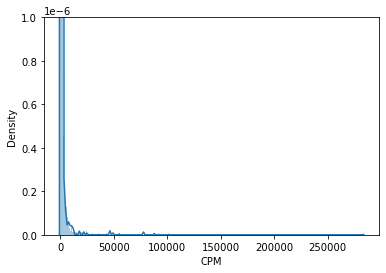

In [25]:
# Distribution of CPM
sns.distplot(df['CPM'],bins=1000)
plt.ylabel("Density")
plt.ylim((0,0.000001))

In [26]:
df['CPM'].value_counts()

0.000000      276330
10.000000      15772
20.000000      11898
200.000000      9756
30.000000       9136
               ...  
318.509804         1
439.054726         1
90.810811          1
478.575096         1
423.265306         1
Name: CPM, Length: 35879, dtype: int64

As it can be seen from above distribtuon plot and value counts,that there are plenty of zeros and as well as outliers as fars as till ~3k. Let us remove outlier first from data and see if metrics improves

7.2 Approach 2 : ML model - XGBoost\
    * Model after removing outliers

Outliers removel

In [27]:
# Remove outliers 
df_1 = df[df.CPM < df.CPM.quantile(.95)]
df_1 = df_1[df_1.CPM >= 0]

C:\Users\JD\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Density')

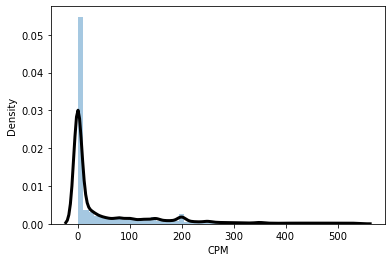

In [28]:
ax=sns.distplot(df_1['CPM'], kde_kws={"color": "k", "lw": 3, "label": "KDE"})
plt.ylabel("Density")
#plt.ylim((0,0.000001))

In [29]:
# For modelling
X = df_1.drop(columns=['date',"CPM"]) 
y = df_1['CPM']

Training and testing points
    * Selection based on date 06-22-2019

In [30]:
# train_X, val_X, train_y, val_y = train_test_split(X, y,random_state = seed)
train_X = X.loc[df_1.date < pd.Timestamp('06-22-2019')]
val_X = X.loc[df_1.date >= pd.Timestamp('06-22-2019')]
train_y = y.loc[df_1.date < pd.Timestamp('06-22-2019')]
val_y_o = y.loc[df_1.date >= pd.Timestamp('06-22-2019')]

XGBoost model fitting

In [31]:
# Model fitting using XGBoost
model_xgb2 = xgb.XGBRegressor()
model_xgb2.fit(train_X, train_y)
xgb_preds_noout = model_xgb2.predict(val_X)

[16:11:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Error metric evaluation

In [32]:
print("MAE:", mean_absolute_error(val_y_o, xgb_preds_noout))
print("MSE:", mean_squared_error(val_y_o, xgb_preds_noout))
print("R2:",r2_score(val_y_o,xgb_preds_noout))

MAE: 46.87161615239008
MSE: 6145.12708707932
R2: 0.44944504640902416


Model performance did improve a bit, it seems that we need to deal with zeros first as it can be reason that heavy tail making our model biased towards it
1. We are going to use two staged approach here
2. Stage 1: Build model to classify if the CPM is zero or not
3. Stage 2: regression model to regress for predicted non zero class
4. Ensemble this to get final predictions

7.3 Approach 3 : ML model - XGBoost\
    * Modelling after removing outliers\
    * Stage 1: Build model to classify if the CPM is zero or not\
    * Stage 2: regression model to regress for predicted non zero class\
    * Ensemble this to get final predictions\

Classifying CPM data

In [33]:
df['CPM_cat'] = np.where(df["CPM"]>0,1,0)

In [34]:
df['CPM_cat'].value_counts()

0    276331
1    267796
Name: CPM_cat, dtype: int64

We can use accuracy as metric as it can be seen that the classes are nearly balanced

In [35]:
y_clf = df['CPM_cat']
X_clf = df.drop(columns=['date',"CPM",'CPM_cat']) # For modelling

Training and testing points
    * Selection based on date 06-22-2019

In [36]:
train_X_clf = X_clf.loc[df.date < pd.Timestamp('06-22-2019')]
val_X_clf = X_clf.loc[df.date >= pd.Timestamp('06-22-2019')]
train_y_clf = y_clf.loc[df.date < pd.Timestamp('06-22-2019')]
val_y_clf = y_clf.loc[df.date >= pd.Timestamp('06-22-2019')]

XGBoost model fitting

In [37]:
model_xgb_clf = xgb.XGBClassifier()
model_xgb_clf.fit(train_X_clf, train_y_clf)
xgb_preds_clf = model_xgb_clf.predict(val_X_clf)
print('acc',accuracy_score(val_y_clf,xgb_preds_clf))

acc 0.8899011200719569


Hyper parameter optimization
     for classified CPM data

In [38]:
# Function used in hyper parameter optimization with the parameters

def objective(trial):
  

    param = {
        "silent": 1,
        "objective": "binary:logistic",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
        "max_depth":trial.suggest_int("max_depth",4,10),
        "colsample_bytree": trial.suggest_float("colsample_bytree",.6,1.),
        "subsample":trial.suggest_float("subsample",.7,1.),

    }

    y_clf = df['CPM_cat']
    X_clf = df.drop(columns=['date',"CPM",'CPM_cat']) # For modelling
    
    # train_X_clf, val_X_clf, train_y_clf, val_y_clf = train_test_split(X_clf, y_clf, random_state = seed)
    train_X_clf = X_clf.loc[df.date < pd.Timestamp('06-22-2019')]
    val_X_clf = X_clf.loc[df.date >= pd.Timestamp('06-22-2019')]
    train_y_clf = y_clf.loc[df.date < pd.Timestamp('06-22-2019')]
    val_y_clf = y_clf.loc[df.date >= pd.Timestamp('06-22-2019')]

    model_xgb_clf = xgb.XGBClassifier(**param)
    model_xgb_clf.fit(train_X_clf, train_y_clf)
    xgb_preds_clf = model_xgb_clf.predict(val_X_clf)
    print('acc',accuracy_score(val_y_clf,xgb_preds_clf))


    return accuracy_score(val_y_clf,xgb_preds_clf)

In [39]:
# Parameters after hyper parameter optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials = 5)

[I 2021-03-22 16:12:12,930] A new study created in memory with name: no-name-f654aefc-78a0-49d8-bd0d-fe3bea20557b
[I 2021-03-22 16:12:19,531] Trial 0 finished with value: 0.7442553010459272 and parameters: {'booster': 'gblinear', 'lambda': 0.20053489318285, 'alpha': 0.07043613173080274, 'max_depth': 7, 'colsample_bytree': 0.6096410052387309, 'subsample': 0.8829837938129335}. Best is trial 0 with value: 0.7442553010459272.


acc 0.7442553010459272


[I 2021-03-22 16:14:09,120] Trial 1 finished with value: 0.9046206766620275 and parameters: {'booster': 'dart', 'lambda': 0.009636422788918644, 'alpha': 0.06872811203562414, 'max_depth': 9, 'colsample_bytree': 0.8133021803465543, 'subsample': 0.9921077670622159}. Best is trial 1 with value: 0.9046206766620275.


acc 0.9046206766620275


[I 2021-03-22 16:14:15,694] Trial 2 finished with value: 0.7442553010459272 and parameters: {'booster': 'gblinear', 'lambda': 0.4690909194288006, 'alpha': 2.1654273731987882e-05, 'max_depth': 7, 'colsample_bytree': 0.9932590460353194, 'subsample': 0.8224115318836581}. Best is trial 1 with value: 0.9046206766620275.


acc 0.7442553010459272


[I 2021-03-22 16:14:22,267] Trial 3 finished with value: 0.7442553010459272 and parameters: {'booster': 'gblinear', 'lambda': 7.076825377005214e-05, 'alpha': 0.06290570842837759, 'max_depth': 8, 'colsample_bytree': 0.6796986436759367, 'subsample': 0.8978906322707163}. Best is trial 1 with value: 0.9046206766620275.


acc 0.7442553010459272


[I 2021-03-22 16:14:48,080] Trial 4 finished with value: 0.9019952231331627 and parameters: {'booster': 'gbtree', 'lambda': 5.46443180669114e-07, 'alpha': 0.00610746245909336, 'max_depth': 7, 'colsample_bytree': 0.7160446808807253, 'subsample': 0.9036182565173605}. Best is trial 1 with value: 0.9046206766620275.


acc 0.9019952231331627


Fit model for classifier

In [40]:
model_xgb_clf = xgb.XGBClassifier(**study.best_params)
model_xgb_clf.fit(train_X_clf, train_y_clf)
xgb_preds_clf = model_xgb_clf.predict(val_X_clf)
print('acc',accuracy_score(val_y_clf,xgb_preds_clf))

acc 0.9046206766620275


In [41]:
X.shape,df.shape

((516885, 13), (544127, 16))

Oulier removal

In [42]:
df = df[df['CPM']<np.percentile(df['CPM'],95)]
df = df[df['CPM']>=0]

In [43]:
df.shape

(516885, 16)

In [44]:
df['CPM_cat_pred'] = list(model_xgb_clf.predict(df[X.columns]))

In [45]:
df['CPM_cat_pred'].shape

(516885,)

Model fitting after hyper parameter optimization and outlier removal

In [46]:
y_reg = df['CPM']
X_reg = df.drop(columns=['date',"CPM",'CPM_cat']) # For modelling

Training and testing points
    * Selection based on date 06-22-2019

In [47]:
train_X_reg = X_reg.loc[df.date < pd.Timestamp('06-22-2019')]
val_X_reg = X_reg.loc[df.date >= pd.Timestamp('06-22-2019')]
train_y_reg = y_reg.loc[df.date < pd.Timestamp('06-22-2019')]
val_y_reg = y_reg.loc[df.date >= pd.Timestamp('06-22-2019')]

Training and testing points\
    * Selection based on date 06-22-2019

XGBoost model fitting

In [48]:
model_xgb_reg = xgb.XGBRegressor()
model_xgb_reg.fit(train_X_reg, train_y_reg)
xgb_preds_reg = model_xgb_reg.predict(val_X_reg)

print("MAE:", mean_absolute_error(val_y_reg, xgb_preds_reg))
print("MSE:", mean_squared_error(val_y_reg, xgb_preds_reg))
print("R2:",r2_score(val_y_reg,xgb_preds_reg))

[16:16:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE: 44.9503788611161
MSE: 5954.152766525438
R2: 0.46655484034814065


7.4 Approach 4\
     * Feature seletion based on correlation analysis 

Correlation analysis - using heatmap 

(544127, 13)

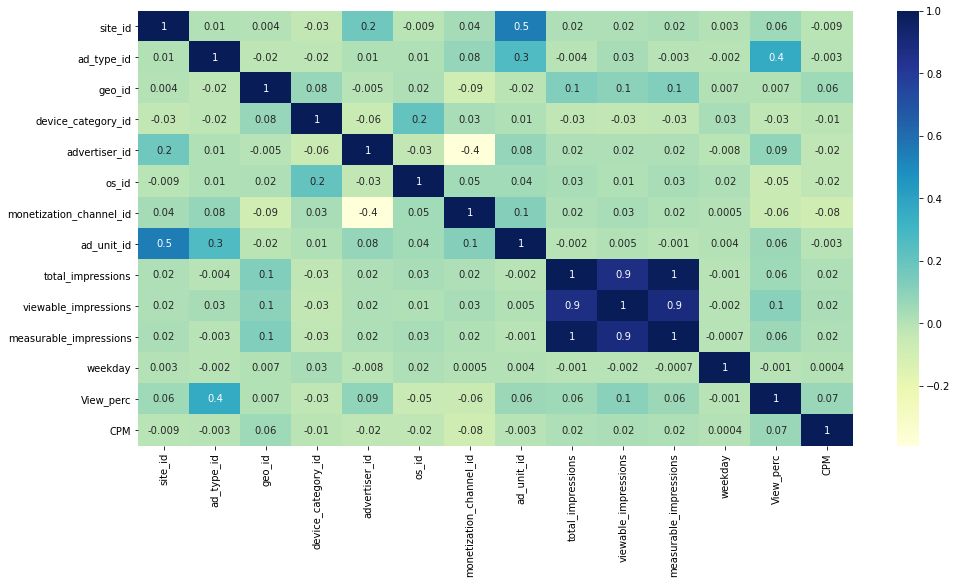

In [49]:
# Correalation between each variables 
df_fortest = df_corr.drop(['total_revenue'],axis=1)
plt.figure(figsize=(16,8))
sns.heatmap(df_fortest.corr(),annot = True,cmap="YlGnBu",fmt='.1g')

# Inference
# Total and viewable are are highly correlated(>0.85) with total impressions
# Total and viewable are dropped from the data set

df_fortest = df_fortest.drop(['measurable_impressions','viewable_impressions'],axis=1)
df_fortest.shape

Model selction

In [50]:
y_reg_cor = df_fortest['CPM']
X_reg_cor = df_fortest.drop(columns=['date','CPM']) # For modelling

Training and testing points
    * Selection based on date 06-22-2019

In [51]:
train_X_reg_cor = X_reg_cor.loc[df_fortest.date < pd.Timestamp('06-22-2019')]
val_X_reg_cor = X_reg_cor.loc[df_fortest.date >= pd.Timestamp('06-22-2019')]
train_y_reg_cor = y_reg_cor.loc[df_fortest.date < pd.Timestamp('06-22-2019')]
val_y_reg_cor = y_reg_cor.loc[df_fortest.date >= pd.Timestamp('06-22-2019')]

XGBoost model fitting

In [52]:
model_xgb_reg_cor = xgb.XGBRegressor()
model_xgb_reg_cor.fit(train_X_reg_cor, train_y_reg_cor)
xgb_preds_reg_cor = model_xgb_reg_cor.predict(val_X_reg_cor)

print("MAE:", mean_absolute_error(val_y_reg_cor, xgb_preds_reg_cor))
print("MSE:", mean_squared_error(val_y_reg_cor, xgb_preds_reg_cor))
print("R2:",r2_score(val_y_reg_cor,xgb_preds_reg_cor))

[16:16:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE: 107.60195227413625
MSE: 331073.8535849695
R2: 0.08664836581084467


Further study is not required as mentioned in approach 2 (removal of outliers) and approach 3 ( Ensembling regression and classification after Hyper parameter optimization)\
Since this approach gives similar error metrics compared to approach 1. Upgrading this will provide outcomes similar to approach 2 and approach 3. So the further study is ignored.

# Model selection

In [53]:
# R2 error comparison
print("R2_1:",r2_score(val_y,xgb_preds))
print("R2_2:",r2_score(val_y_o,xgb_preds_noout))
print("R2_3:",r2_score(val_y_reg,xgb_preds_reg))
print("R2_4:",r2_score(val_y_reg_cor,xgb_preds_reg_cor))

R2_1: 0.08742662833759507
R2_2: 0.44944504640902416
R2_3: 0.46655484034814065
R2_4: 0.08664836581084467


In [54]:
# MSE error comparison
print("MSE_1:", mean_squared_error(val_y, xgb_preds))
print("MSE_2:", mean_squared_error(val_y_o, xgb_preds_noout))
print("MSE_3:", mean_squared_error(val_y_reg, xgb_preds_reg))
print("MSE_4:", mean_squared_error(val_y_reg_cor, xgb_preds_reg_cor))

MSE_1: 330791.74714952114
MSE_2: 6145.12708707932
MSE_3: 5954.152766525438
MSE_4: 331073.8535849695


In [55]:
# MAE error
print("MAE_1:", mean_absolute_error(val_y, xgb_preds))
print("MAE_2:", mean_absolute_error(val_y_o, xgb_preds_noout))
print("MAE_3:", mean_absolute_error(val_y_reg, xgb_preds_reg))
print("MAE_4:", mean_absolute_error(val_y_reg_cor, xgb_preds_reg_cor))

MAE_1: 107.33936764099386
MAE_2: 46.87161615239008
MAE_3: 44.9503788611161
MAE_4: 107.60195227413625


Based on the error metric model from approach 3 is choosed as best fit to the data.
For example, MAE error is reduced around 41%\
Apporch 3 consists: \
    * Model bulit with XGBoost ML algorithm\
    * Outliers are not considered in CPM\
    * Hyper parameter optimization is carried out to identify the best parameter combinations for XGBoost\
    * Error metric comparison with approach 1

In [56]:
best_df= pd.DataFrame({})
best_df['CPM_actual']= val_y_reg

In [57]:
best_df['Pred_CPM'] = xgb_preds_reg

Revenue calculation

In [58]:
revenue_df = pd.DataFrame({'Actual_Impressions': val_X_reg['total_impressions'].values,  'CPM_actual': val_y_reg, 
                           'Pred_CPM': best_df['Pred_CPM'].values})

revenue_df['Pred_Rev'] = revenue_df['Pred_CPM'] * revenue_df['Actual_Impressions'] / (1000 * 100)
revenue_df['Pred_Rev'] = revenue_df['Pred_Rev'].clip(lower=0)
revenue_df.sample(n=5)

,Actual_Impressions,CPM_actual,Pred_CPM,Pred_Rev
117125,4,140.0,139.165878,0.005567
78708,0,0.0,13.942388,0.000000
82690,132,125.0,93.604446,0.123558
8817,0,0.0,-3.301842,-0.000000
165123,0,0.0,-0.858597,-0.000000


# Questions

1. What is the potential revenue range our publisher can make in July?

In [73]:
print('Average revenue of june month:', np.round(Xact["total_revenue"].mean(),2))
P =np.round(revenue_df["Pred_Rev"].mean(),2)
print('Predicted revenue range of july month:', np.round(P-P*0.2,2),np.round(P+P*0.2,2))

Average revenue of june month: 0.07
Predicted revenue range of july month: 0.05 0.07


2. What is the reserve prices that he/she can set ?

In [60]:
print('Reserve price of june month:', np.round(best_df["CPM_actual"].max(),2))
print('Predicted reserve price of july month:',np.round(best_df["Pred_CPM"].max(),2))

Reserve price of june month: 540.0
Predicted reserve price of july month: 394.35
